# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [577]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import timeit
import pickle
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Part 0: Wrangling and EDA

### 0.1 Loading data

In [578]:
# CUSTOMER TABLE 

customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# POPULATION DATA
population = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# From a saved pickle file to accelerate loading process

#with open('population_full', 'rb') as f1:
#    population = pickle.load(f1)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [356]:
# DESCRIPTION DATA

description=pd.read_excel('DIAS Attributes - Values 2017.xlsx',header=1)

In [357]:
# Shape of all dataframes
population.shape, customers.shape, description.shape

((891221, 366), (191652, 369), (2258, 4))

### 0.2 Assessing and cleaning data

### Assessing 

In [358]:
%%time
# To accelerate the process , lets get a sample of each dataframes

#pop = population.sample(n=5000, random_state=10)
#cust = customers.sample(n=5000,random_state=10)

pop = population
cust = customers

CPU times: user 1.68 s, sys: 3.14 s, total: 4.82 s
Wall time: 3min 25s


##### Population data

In [395]:
# let's have a view of data
pop.head(4)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
205964,300509,2,1.0,0.0,17.0,NaN,NaN,NaN,12.0,6.0,...,4.0,2.0,4.0,2.0,1.0,9.0,3.0,3,1,3
543582,778553,-1,3.0,16.0,11.0,13.0,NaN,NaN,16.0,2.0,...,2.0,3.0,6.0,9.0,1.0,9.0,2.0,4,2,1
704843,590887,-1,1.0,21.0,NaN,NaN,NaN,NaN,14.0,2.0,...,2.0,3.0,5.0,3.0,2.0,9.0,3.0,4,1,3
52057,739485,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,1.0,...,2.0,4.0,7.0,5.0,4.0,9.0,3.0,1,1,3


In [396]:
# lets have a global view of data
pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 205964 to 673411
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 14.0+ MB


In [397]:
# lets see the 6 objects features
list(pop.select_dtypes(include='object').columns)

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [430]:
# lets see the 6 objects features
pop.select_dtypes(include='object').nunique()

CAMEO_DEU_2015               45
CAMEO_DEUG_2015              19
CAMEO_INTL_2015              43
D19_LETZTER_KAUF_BRANCHE     35
EINGEFUEGT_AM               609
OST_WEST_KZ                   2
dtype: int64

These variables contain a large number of modalities. This will require special reprocessing in the cleaning phase.

In [398]:
# it seems like we have a bunch of unknowns values for numerical features (360 out of 366 features)
pop.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,5.000000e+03,5000.000000,4584.000000,4584.000000,433.000000,152.00000,41.000000,12.000000,3508.000000,4453.000000,...,4295.000000,4568.000000,4568.000000,4568.000000,4398.000000,4584.000000,4453.000000,5000.000000,5000.000000,5000.000000
mean,6.362010e+05,-0.325200,4.366928,10.728185,11.764434,13.12500,14.024390,15.250000,13.559578,8.251067,...,2.409779,5.974168,7.551445,5.942863,3.935198,7.884380,4.090052,3.319200,1.510800,2.798800
std,2.590800e+05,1.219566,3.624860,7.665340,4.179971,3.32622,2.514834,1.815339,5.088903,15.261919,...,1.169476,2.833337,3.198009,2.762082,1.970012,1.926804,1.951161,1.354577,0.499933,1.048303
min,1.916600e+05,-1.000000,1.000000,0.000000,2.000000,6.00000,8.000000,12.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.101110e+05,-1.000000,1.000000,0.000000,8.000000,10.00000,12.000000,15.000000,11.000000,1.000000,...,2.000000,4.000000,6.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.396100e+05,-1.000000,2.000000,13.000000,12.000000,13.00000,14.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,4.000000,3.000000,2.000000,3.000000
75%,8.587825e+05,0.000000,9.000000,17.000000,16.000000,16.00000,16.000000,16.250000,17.000000,9.000000,...,3.000000,8.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082578e+06,3.000000,9.000000,21.000000,18.000000,18.00000,18.000000,18.000000,25.000000,367.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


Total of NAns values :  192507


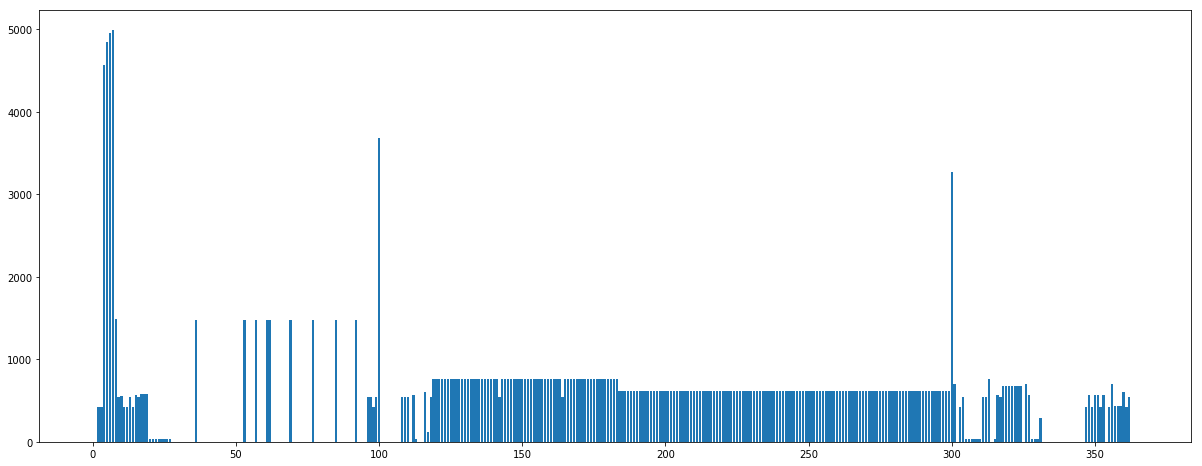

In [399]:
print("Total of NAns values : ",pop.isnull().sum().sum())
fig, ax = plt.subplots(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(pop.columns)), pop.isnull().sum());

It appears that some columns are essentially composed of missing data. it is for the majority the first columns of our dataframe.We will only retain for our analysis those columns that do not contain more than 40% of missing data. This will allow us to eliminate columns with too much missing data.

In [400]:
# Lets see columns with more than 40% Nas
mask = (pop.isnull().sum()/pop.shape[0])>0.4
pop.columns[mask]

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

Before proceeding to remove these columns, we need to perform the same analysis with the customer data. Indeed, we must arrive at a common base of columns between the two dataframes in order to perform clustering.

##### Customer data

In [401]:
# let's have a view of data
cust.head(4)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
159816,17567,2,1.0,0.0,8.0,11.0,NaN,NaN,8.0,1.0,...,1.0,1.0,9.0,7.0,4,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
148697,190614,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,COSMETIC,MULTI_BUYER,0,2,3
147293,142965,-1,1.0,15.0,15.0,17.0,NaN,NaN,0.0,1.0,...,2.0,1.0,9.0,2.0,1,FOOD,SINGLE_BUYER,0,1,4
86196,108216,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,2,4


In [402]:
cust.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,5000.000000,5000.000000,3795.000000,3795.000000,317.000000,139.000000,31.000000,6.000000,3646.000000,3712.000000,...,3764.000000,3764.000000,3764.000000,3600.000000,3795.000000,3712.000000,5000.00000,5000.00000,5000.000000,5000.00000
mean,97428.018600,0.348600,1.768116,11.330171,12.258675,13.690647,15.322581,17.333333,10.417992,4.839978,...,4.407811,4.573592,3.157014,4.159167,8.628986,3.778556,2.59240,0.09000,1.375200,3.06580
std,55629.238987,1.389483,2.014441,6.222616,4.005056,3.157345,2.357783,0.816497,4.027920,12.362953,...,2.923282,2.866533,2.181640,1.965088,1.168648,2.099516,1.17989,0.28621,0.484223,1.08559
min,11.000000,-1.000000,1.000000,0.000000,2.000000,6.000000,8.000000,16.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.00000,1.000000,1.00000
25%,48984.750000,-1.000000,1.000000,8.000000,9.000000,11.500000,15.000000,17.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.00000,0.00000,1.000000,3.00000
50%,99124.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,17.500000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.00000,0.00000,1.000000,3.00000
75%,145917.750000,2.000000,1.000000,16.000000,16.000000,17.000000,17.500000,18.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.00000,0.00000,2.000000,4.00000
max,191642.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,321.000000,...,10.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.00000,1.00000,2.000000,9.00000


Total of NAns values :  357441


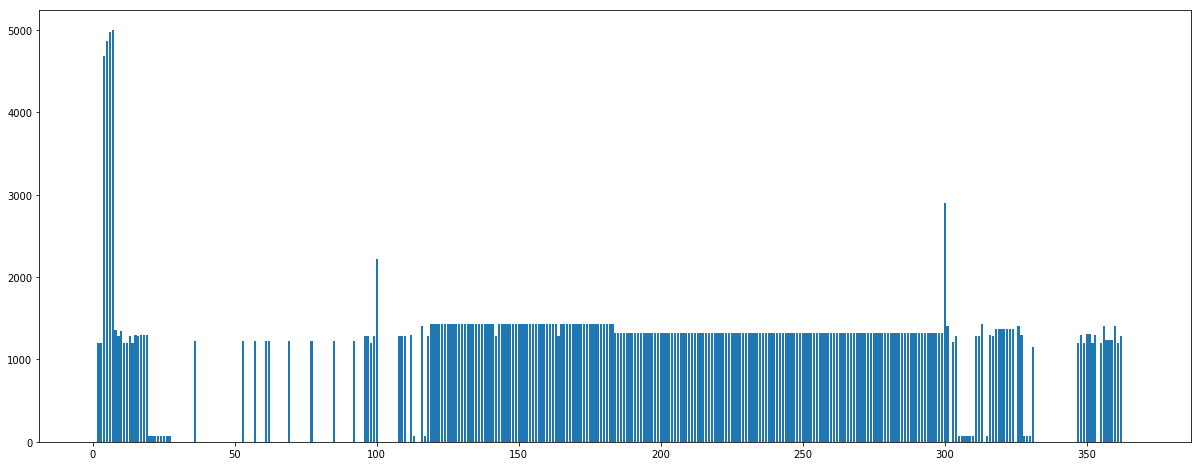

In [403]:
print("Total of NAns values : ",cust.isnull().sum().sum())
fig, ax = plt.subplots(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(cust.columns)), cust.isnull().sum());

The analysis is the same as that carried out on the overall population.

In [404]:
# Lets see columns with more than 40% Nas
mask_cust = (cust.isnull().sum()/cust.shape[0])>0.4
cust.columns[mask_cust]

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

These are the same columns as in the overall population. these columns can therefore be eliminated. Before clustering, we need to make sure that both dataframes (population and customer) contain exactly the same columns so that the resulting clusters are comparable.

In [405]:
#lets see the difference between customer and population dataframes columns
print(cust.columns.symmetric_difference(pop.columns))

Index(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='object')


In [406]:
cust = cust[pop.columns]

Let's delete the LNR variable that identifies each client in both dataframes.

In [573]:
cust = cust.drop('LNR',axis = 1)
pop = pop.drop('LNR',axis=1)

##### Description data

In [407]:
description.head(5)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


It appears that some missing data has been encoded in specific values (-1 for example) for some columns. We need to identify these values and replace them with Nas.

In [408]:
# let's find theses values
# we have -1, 0, and 9 and 10. But we have to make some treatment to get the right value and the right column.
description[description.Meaning.str.contains('know',na=False)]#,na=False)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
NaN,ANREDE_KZ,gender,"-1, 0",unknown
NaN,BALLRAUM,distance to next urban centre,-1,unknown
NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
NaN,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
NaN,CJT_GESAMTTYP,customer journey typology,0,unknown
NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known


In [409]:
# We will not use the column "description". let's delete it.
# We will also remove all the rows containing NAN to keep only the one identified as "missing or unknown data".
description= description[['Attribute','Value','Meaning']]
description=description[description.Attribute.notna()].reset_index(drop=True)

In [410]:
description.head(5)

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,ALTERSKATEGORIE_GROB,"-1, 0",unknown
2,ALTER_HH,0,unknown / no main age detectable
3,ANREDE_KZ,"-1, 0",unknown
4,ANZ_HAUSHALTE_AKTIV,…,numeric value (typically coded from 1-10)


### Cleaning

After evaluating the data, we will proceed to clean up the data by writing the necessary functions. Our approach is as follows.
- Delete columns with more than 40% NAs
- clean the dataframe description to identify the values to be transformed into nas
- replace unknown values by NAs
- Input missing values by :
    - Numerical features => Median
    - Categorical features => Most frequent (Mode)
- Encode data
    - Binary features => transform values to [0,1]      
    - All other features => one hot encoding
- Scale data using the StandardScaler method from sklearn

In [411]:
# Delete columns with more than 40% NAs

def delete_nas(df):
    '''
    Delete columns with more than 40% NAs and rows with more than 50% Nas
    INPUT : 
        df [dataframe]: a dataframe to clean
        
    OUTPUT:
        dt : the cleaned data
    '''
  
    print("Before columns deleting , data shape : {} ".format(df.shape))
    mask = (df.isnull().sum()/df.shape[0])>0.4
    dt=df[df.columns[~mask]]
    print("After columns deleting , data shape : {} ".format(dt.shape))
    
    mask = (dt.isnull().sum(axis=1)/dt.shape[1])>0.5# Rows 
    dt = dt[~mask]
    print("After rows deleting , data shape : {} ".format(dt.shape))
    
    return dt    

In [412]:
# clean the dataframe description to identify the values to be transformed into nas

def clean_description(description):
    '''
    Clean the dataframe description to identify the values to be transformed into nas
    INPUT : 
        description [dataframe]: description data
    
    OUTPUT:
        dt : the description containing only values uded to encode unknown data
    '''
    dt=description.copy()
    dt = dt[dt.Meaning.str.contains('know',na=False)].reset_index(drop=True)
    
    s = dt['Value'].str.split(',').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(1)
    s.name='replace_value'
    dt = dt.join(s)
    dt.loc[dt.replace_value.isna(),'replace_value']=dt[~dt.Value.str.contains(',',na=False)].Value
    dt.reset_index(drop=True,inplace=True)
    dt['replace_value']=dt['replace_value'].astype(float)
    
    return dt

# replace unknown values by NAs

def unknown_to_nas(df,description_c):
    '''
    replace unknown values by NAs
    INPUT : 
        df [dataframe]: a dataframe to clean
        description_c [dataframe]: the cleaned description data
        
    OUTPUT:
        dt : the cleaned data
    '''
    dt = df.copy()
    cols = df.columns.intersection(description_c.columns)
    for i in range(len(description_c[cols])):
        value = description_c.loc[i,'replace_value']
        col = description_c.loc[0,'Attribute']
        mask = dt[col] == value
        dt[mask]= np.nan
        
    return dt

In [505]:
# Input missing values by Median (numerical) or Mode (others)

def input_nas(df,description_c):
    '''
    Input missing values by Median (numerical) or Mode (others)
    INPUT : 
        df [dataframe]: a dataframe to clean
        description_c [dataframe]: the cleaned description data
        
    OUTPUT:
        data : the cleaned data
    '''
    dt=description_c.copy()
    data=df.copy()
    
    dt=dt[dt.Meaning.str.contains('numeric',na=False)]
    #dt.reset_index(drop=True,inplace=True)

    print("Number of Nas before filling : {}".format(data.isnull().sum().sum()))
    # Numerical features => Median
    mask = dt.Attribute.values
    data[mask]= data[mask].fillna(data.median())
    print("Number of Nas after filling Numeric features : {}".format(data.isnull().sum().sum()))
    
    # Categorical features => Most frequent (Mode)
    mask = data.columns.difference(mask)
    data[mask]= data[mask].fillna(data.mode().iloc[0])
    print("Number of Nas after  filling All features: {}".format(data.isnull().sum().sum()))
    
    return data#.reset_index(drop=True)

In [506]:
# Encode data    - Binary features => transform values to [0,1] 
    
def encode_data(df,description_c):
    '''
    Encode categorical data
    INPUT : 
        df [dataframe]: a dataframe to clean
        
    OUTPUT:
        df : the cleaned data
    '''
    # encode CAMEO features
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    df.fillna(0,inplace=True)
    
    # drop some features
    cols= ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','OST_WEST_KZ']
    df=df.drop(columns=cols,axis=1)
    
    # Scale numerical Numerical features
    scaler = StandardScaler()
    scaled_arr = scaler.fit_transform(df)
    data_scaled = pd.DataFrame(scaled_arr, columns = df.columns)
    df =data_scaled
    
    return df

In [460]:
list(pop.select_dtypes(include='object').columns)

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [507]:
def process_data(data,description):
    '''
    Clean data from beginning to end
    INPUT : 
        data [dataframe]: a dataframe to clean
        description [dataframe]: the description data
    OUTPUT:
        data : the scaled data
    '''
    # clean description data
    print("Cleaning description data ...")
    description_c = clean_description(description)
    
    # delete Nas
    print("Deleting Nas columns ...")
    data = delete_nas(data)
    
    # replace Unknown by  Nas
    print("Replacing Unknowns by Nas ...")
    data = unknown_to_nas(data,description_c)
    
    # input nas
    print("Inputing Nas values ...")
    data = input_nas(data,description_c)
    
    # encode data
    print("Encoding data ...")
    data = encode_data(data,description_c)
    
    data.fillna(method='ffill',inplace=True)
    
    print(data.shape)
    
    return data
    

#### lets clean data

In [508]:
%%time
pop_c = process_data(pop,description)

Cleaning description data ...
Deleting Nas columns ...
Before columns deleting , data shape : (5000, 366) 
After columns deleting , data shape : (5000, 360) 
After rows deleting , data shape : (4418, 360) 
Replacing Unknowns by Nas ...
Inputing Nas values ...
Number of Nas before filling : 1173403
Number of Nas after filling Numeric features : 1173403
Number of Nas after  filling All features: 0
Encoding data ...
(4418, 356)
CPU times: user 41.3 s, sys: 20.6 ms, total: 41.3 s
Wall time: 41.7 s


In [509]:
%%time
cust_c=process_data(cust,description)

Cleaning description data ...
Deleting Nas columns ...
Before columns deleting , data shape : (5000, 366) 
After columns deleting , data shape : (5000, 360) 
After rows deleting , data shape : (3694, 360) 
Replacing Unknowns by Nas ...
Inputing Nas values ...
Number of Nas before filling : 463496
Number of Nas after filling Numeric features : 463496
Number of Nas after  filling All features: 0
Encoding data ...
(3694, 356)
CPU times: user 39.6 s, sys: 0 ns, total: 39.6 s
Wall time: 39.9 s


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In this part we will proceed in two steps: 
- the reduction of dimensions with a PCA algorithm. By using a dimensionality reduction technique, we can effectively reduce the number of features which do not vary much in the data.
- clustering using the KNN algorithm

### Dimension reduction

##### customer data

CPU times: user 1.66 s, sys: 0 ns, total: 1.66 s
Wall time: 1.71 s


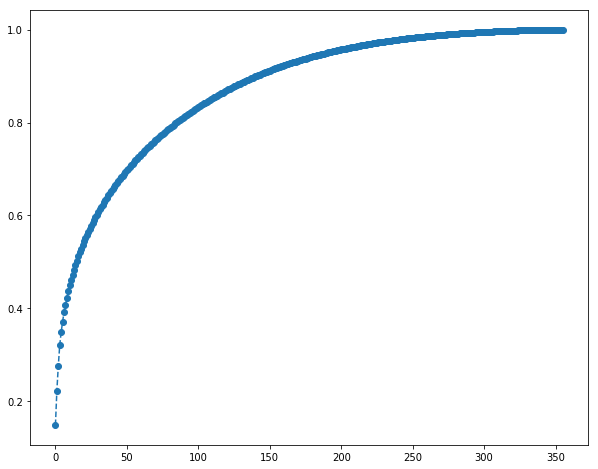

In [510]:
%%time

pca = PCA() # init pca
pca.fit(pop_c) # fit the dataset into pca model

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
cumulativeValue = pca.explained_variance_ratio_.cumsum()

#we can plot the cumulative value as below
plt.figure(figsize= (10, 8)) # size of the chart(size of the vectors)
plt.plot(ind, cumulativeValue, marker = 'o', linestyle="--");

In [511]:
df= pd.DataFrame(cumulativeValue,columns=["cum_variance"])
mask=df.cum_variance > 0.90

In [512]:
df[mask].index[0]

141

**According to the graph above we are able to explain 90% of the variance with 141 variables. This is the value we will retain.**

CPU times: user 526 ms, sys: 3.69 ms, total: 530 ms
Wall time: 545 ms


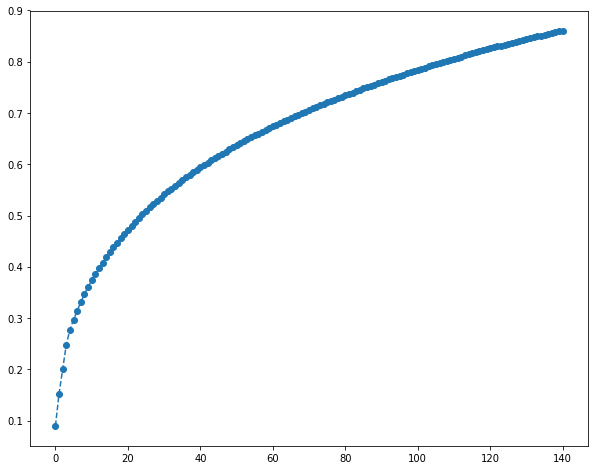

In [513]:
%%time
pca = PCA(141) # init pca
customer_pca=pca.fit_transform(cust_c) # fit the dataset into pca model

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
cumulativeValue = pca.explained_variance_ratio_.cumsum()

#we can plot the cumulative value as below
plt.figure(figsize= (10, 8)) # size of the chart(size of the vectors)
plt.plot(ind, cumulativeValue, marker = 'o', linestyle="--");

In [514]:
def plot_features(data, pca, pc_num):
    
    p_comp = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[pc_num]
    p_comp.sort_values(ascending=False, inplace=True)
    p_comp = pd.concat([p_comp.head(5), p_comp.tail(5)])
    
    p_comp.plot(kind='bar', title='Principal Component ' + str(pc_num))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

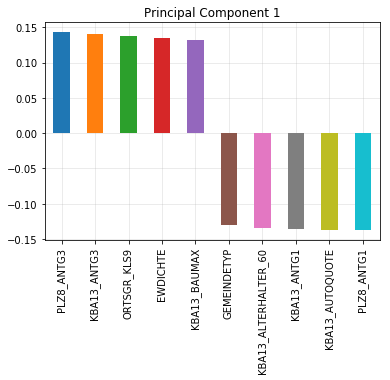

In [515]:
plot_features(cust_c,pca,1)

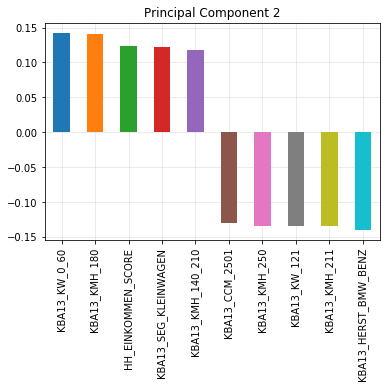

In [516]:
plot_features(cust_c,pca,2)

##### population data

In [517]:
%%time
pca = PCA(141) # init pca
population_pca=pca.fit_transform(pop_c) # fit the dataset into pca model

CPU times: user 589 ms, sys: 2 µs, total: 589 ms
Wall time: 590 ms


### Clustering

CPU times: user 15.1 s, sys: 2.71 ms, total: 15.1 s
Wall time: 15.2 s


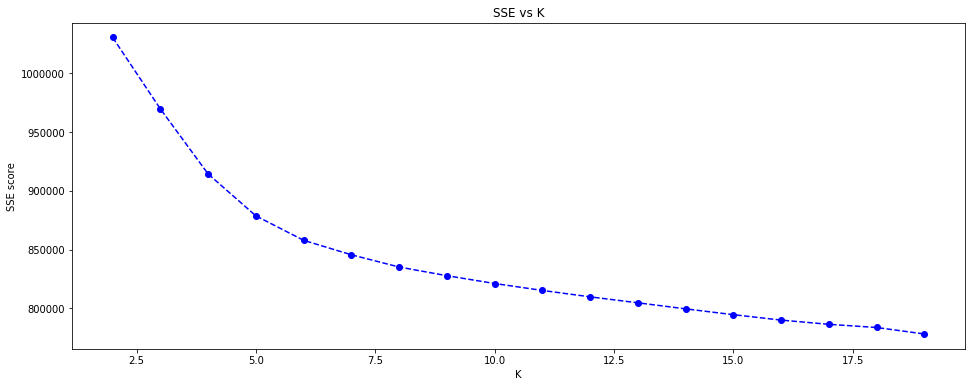

In [518]:
%%time
# lets find out the optimal number of clusters

def fit_kmeans(data, centers):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    
    '''
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    # SSE score for kmeans model 
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(2,20))
for center in centers:
    scores.append(fit_kmeans(customer_pca, center))
    
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plot the original data with clusters
plt.figure(figsize=(16, 6))
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.ylabel('SSE score')
plt.xlabel('K')
plt.title('SSE vs K')

There is no clear elbow in the plot. From the elbow above, we can see that the sum of sqaured error decreasing with a high slope until around 10 clusters and then the slope decreases. We are going to perform our analyses by selecting the first 10 clusters.

In [519]:
kmeans = KMeans(n_clusters = 10)

In [520]:
%%time
# Clustered customer data
kmeans.fit(customer_pca)
customer_clusters=kmeans.predict(customer_pca)

CPU times: user 813 ms, sys: 0 ns, total: 813 ms
Wall time: 819 ms


In [521]:
%%time
# Clustered population data
kmeans.fit(population_pca)
population_clusters=kmeans.predict(population_pca)

CPU times: user 637 ms, sys: 0 ns, total: 637 ms
Wall time: 639 ms


In [522]:
# lets plot the cluster
cluster_info = pd.DataFrame([])

cluster_info["Population"] = pd.Series(population_clusters).value_counts().sort_index()
cluster_info["Customers"] = pd.Series(customer_clusters).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [523]:
cluster_info

,Cluster,Population,Customers
0,0,3248,1271
1,1,24,582
2,2,95,20
3,3,186,46
4,4,125,363
5,5,252,144
6,6,184,432
7,7,6,327
8,8,104,202
9,9,194,307


In [524]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

In [525]:
cluster_info

,Cluster,Population,Customers,Pop_proportion,Cust_proportion
0,0,3248,1271,73.52,34.41
1,1,24,582,0.54,15.76
2,2,95,20,2.15,0.54
3,3,186,46,4.21,1.25
4,4,125,363,2.83,9.83
5,5,252,144,5.70,3.90
6,6,184,432,4.16,11.69
7,7,6,327,0.14,8.85
8,8,104,202,2.35,5.47
9,9,194,307,4.39,8.31


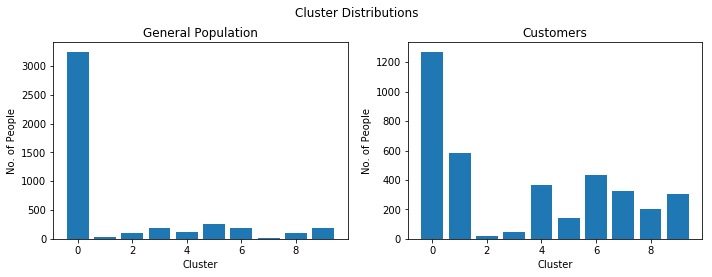

In [526]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

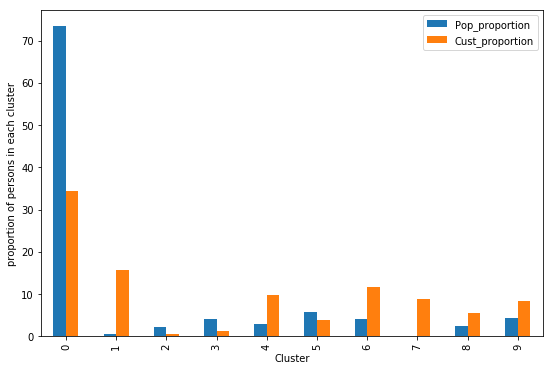

In [527]:
cluster_info.plot(x='Cluster', y = ['Pop_proportion', 'Cust_proportion'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

**The clustering results allow us to affirm that the potential new customers are in clusters 1, 4, 6, 8 and 9. Indeed, we observe a strong presence of the company's customers there.**

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [528]:
%%time
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

CPU times: user 1.44 s, sys: 76.2 ms, total: 1.51 s
Wall time: 1.58 s


<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


In [529]:
mailout_train.shape

(42962, 367)

In [ ]:
mailout_train = mailout_train.drop('LNR',axis=1)

#### cleaning of the mailout data

In [530]:
mailout_train_clean=process_data(mailout_train,description)

Cleaning description data ...
Deleting Nas columns ...
Before columns deleting , data shape : (42962, 367) 
After columns deleting , data shape : (42962, 362) 
After rows deleting , data shape : (35101, 362) 
Replacing Unknowns by Nas ...
Inputing Nas values ...
Number of Nas before filling : 4267894
Number of Nas after filling Numeric features : 4267894
Number of Nas after  filling All features: 0
Encoding data ...
(35101, 358)


In [531]:
mailout_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35101 entries, 0 to 35100
Columns: 358 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(358)
memory usage: 95.9 MB


In [538]:
X = mailout_train_clean.drop(['RESPONSE'], axis=1)
y = mailout_train.loc[mailout_train_clean.index,'RESPONSE']

In [544]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.5)

In [545]:
%%time
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train, y_train)

CPU times: user 1.16 s, sys: 0 ns, total: 1.16 s
Wall time: 1.16 s


In [546]:
%%time
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.986553472737
CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 24.3 ms


**Our model is 98% efficient. We believe that there is certainly overlearning due to the imbalance in the data between the two classes of responses. Accuracy might not be the best metric in this case. Lets find out the value of ROC measure**

In [570]:
roc=roc_auc_score(y_test, logisticRegr.predict_proba(X_test)[:,1])

In [571]:
roc

0.48477761176876222

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [547]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [548]:
mailout_test.shape

(42833, 366)

In [550]:
mailout_test_clean = process_data(mailout_test,description)

Cleaning description data ...
Deleting Nas columns ...
Before columns deleting , data shape : (42833, 366) 
After columns deleting , data shape : (42833, 361) 
After rows deleting , data shape : (35111, 361) 
Replacing Unknowns by Nas ...
Inputing Nas values ...
Number of Nas before filling : 4300859
Number of Nas after filling Numeric features : 4300859
Number of Nas after  filling All features: 0
Encoding data ...
(35111, 357)


In [561]:
submission_kaggle = pd.DataFrame()

In [563]:
submission_kaggle['LNR']= mailout_test.loc[mailout_test_clean.index,'LNR']

In [551]:
#predict target values
kaggle_predict = logisticRegr.predict(mailout_test_clean)[:,1]

In [565]:
submission_kaggle['RESPONSE']=kaggle_predict

In [572]:
submission_kaggle.head(2)

,LNR,RESPONSE
0,1754,0
1,1770,0


In [576]:
submission_kaggle.to_csv('kaggle_submission.csv', index=False)